# Load Dependencies

# ARIM情報活用講座：　ケモインフォマテックス 編　
# 有機合成編

# Google Colabにおける環境設定
google colab環境でなければ実行不要

In [ ]:
!pip install rdkit-pypi
!git clone https://github.com/ARIM-Training/Training_python_7.git
%cd Training_python_7

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn import tree
from sklearn import linear_model
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,BaggingRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error,r2_score
from scipy.stats import pearsonr
from script.feature_selection import circle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
random_seed=2022

# Load Data

In [2]:
import numpy as np

train_num=49
df_data=pd.read_excel('./Data/Data.xlsx')
df_data

,Unnamed: 0,reactant1,reactant2,set1,set2,n(r1)/n(r2),elecricity,T,ratio,8,...,26,27,28,29,30,31,32,33,34,35
0,0,CC1=CC=CC=C1,C=CC(OCCCC)=O,0,1,10,1,60,2.100000,1.702967,...,0.674357,0.677398,0.969871,0.971426,1.081074,1.080450,-0.389886,-0.216763,2.479014,60
1,1,CC1=CC=CC=C1,C=CC(OCCCC)=O,0,2,10,1,60,1.909091,1.702967,...,0.674357,0.677407,0.969871,0.971746,1.081074,1.080049,-0.389886,-0.216763,2.479014,60
2,2,CC1=CC=CC=C1,C=CC(OCCCC)=O,1,2,10,1,60,0.909091,1.703407,...,0.677398,0.677407,0.971426,0.971746,1.080450,1.080049,-0.389886,-0.216763,2.479014,60
3,3,C12=CC=CC=C1C=CC=C2,C=CC(OCCCC)=O,0,1,5,1,60,2.800000,1.700055,...,0.663741,0.666087,0.968543,0.971183,1.081061,1.080405,-0.377368,-0.257932,1.927644,60
4,4,ClC1=C(OC)C=CC=C1,C=CC(OCCCC)=O,0,1,10,1,60,0.625000,1.808682,...,0.645294,0.665523,0.964724,0.970356,1.078336,1.079508,-0.382940,-0.236381,2.087947,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,178,CC1=C(Cl)C=CC=C1Cl,C=CC(OCCCC)=O,0,2,5,1,60,NaN,1.716123,...,0.647493,0.647493,0.966527,0.966527,1.078416,1.078416,-0.403884,-0.249023,2.647464,60
172,179,CC1=C(Cl)C=CC=C1Cl,C=CC(OCCCC)=O,1,2,5,1,60,NaN,1.732552,...,0.649563,0.647493,0.967510,0.966527,1.078610,1.078416,-0.403884,-0.249023,2.647464,60
173,183,CC1=CC(C(C)(C)C)=CC(C(C)(C)C)=C1,C=CC(OCCCC)=O,0,1,5,1,60,NaN,3.247917,...,0.659148,0.665309,0.959024,0.964251,1.076515,1.078161,-0.376850,-0.206119,2.135690,60
174,184,OCC1=CC=CC=C1CO,C=CC(OCCCC)=O,0,1,5,1,60,NaN,1.789384,...,0.680891,16.434056,0.964429,0.970808,1.078049,1.079957,-0.390885,-0.225707,2.425742,60


In [3]:
df_data["reactant1"]

0                          CC1=CC=CC=C1
1                          CC1=CC=CC=C1
2                          CC1=CC=CC=C1
3                   C12=CC=CC=C1C=CC=C2
4                     ClC1=C(OC)C=CC=C1
                     ...               
171                  CC1=C(Cl)C=CC=C1Cl
172                  CC1=C(Cl)C=CC=C1Cl
173    CC1=CC(C(C)(C)C)=CC(C(C)(C)C)=C1
174                     OCC1=CC=CC=C1CO
175                  OC1=CC(C)=CC(C)=C1
Name: reactant1, Length: 176, dtype: object

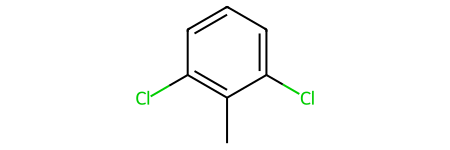

In [4]:
from rdkit import Chem
mol =  Chem.MolFromSmiles(df_data["reactant1"][170])
mol

In [5]:
ratio=np.array(df_data)[:,8][:train_num]
ratio

array([2.1, 1.909090909, 0.909090909, 2.8, 0.625, 0.25, 0.714285714, 0.4,
       1.142857143, 2.857142857, 0.92, 0.073248408, 2.3, 0.079617834, 2.5,
       31.4, 0.625, 0.181818182, 1.6, 8.8, 0.714285714, 1.0, 0.185185185,
       3.083333333, 3.7, 1.2, 1.5, 3.2, 7.6, 3.6, 0.434782609, 19.0, 2.3,
       8.5, 3.269230769, 1.734693878, 0.384615385, 0.204081633,
       0.530612245, 1.0, 1.9, 9.0, 20.0, 5.8, 2.5, 20.0, 20.0, 20.0, 16.0],
      dtype=object)

In [6]:
des_all=np.array(df_data)[:,9:]
des_all

array([[1.702967363, 4.426677994, 6.4236833, ..., -0.2167634,
        2.479014109, 60],
       [1.702967363, 4.426677994, 6.4236833, ..., -0.2167634,
        2.479014109, 60],
       [1.703407058, 4.440689281, 6.42366657, ..., -0.2167634,
        2.479014109, 60],
       ...,
       [3.247916998, 5.749306538, 7.435951689, ..., -0.2061192,
        2.13569039, 60],
       [1.78938393, 5.021015595, 6.468545901, ..., -0.2257069,
        2.425742433, 60],
       [1.703619802, 4.427731217, 7.12607927, ..., -0.212497,
        1.950269335, 60]], dtype=object)

In [7]:
ratio_log=np.array([np.log(i) for i in ratio])
ratio_log

array([ 0.74193734,  0.64662716, -0.09531018,  1.02961942, -0.47000363,
       -1.38629436, -0.33647224, -0.91629073,  0.13353139,  1.04982212,
       -0.08338161, -2.61389877,  0.83290912, -2.53051717,  0.91629073,
        3.44680789, -0.47000363, -1.70474809,  0.47000363,  2.17475172,
       -0.33647224,  0.        , -1.68639895,  1.12601126,  1.30833282,
        0.18232156,  0.40546511,  1.16315081,  2.02814825,  1.28093385,
       -0.83290912,  2.94443898,  0.83290912,  2.14006616,  1.18455472,
        0.55083096, -0.95551144, -1.5892352 , -0.63372376,  0.        ,
        0.64185389,  2.19722458,  2.99573227,  1.75785792,  0.91629073,
        2.99573227,  2.99573227,  2.99573227,  2.77258872])

In [8]:
des_max=des_all[:train_num,:].max(axis=0)
des_min=des_all[:train_num,:].min(axis=0)
des_all_std=(des_all-des_min)/(des_max-des_min)

# Model Selection

In [9]:
models = [BaggingRegressor(random_state=random_seed,n_jobs=60),
          tree.DecisionTreeRegressor(random_state=random_seed),
          ExtraTreesRegressor(random_state=random_seed,n_jobs=60),
          GradientBoostingRegressor(random_state=random_seed,),
          KNeighborsRegressor(n_jobs=60,),KernelRidge(),
          LinearSVR(random_state=random_seed,),RandomForestRegressor(random_state=random_seed,n_jobs=60),
          linear_model.Ridge(random_state=random_seed,alpha=.5),SVR(), 
          xgb.XGBRegressor(random_state=random_seed,n_jobs=60)]

model_names = ['BG','DT','ET','GB','KNR','KRR','LSVR','RF','Ridge','SVR','XGB']
descs = [des_all_std[0:train_num]]
desc_names = ['CD']

In [10]:
loo = LeaveOneOut()
performance_dict = {}

for desc,desc_name in zip(descs,desc_names): 
    desc_=desc
    Y_=np.array(ratio_log[:train_num])
    for model,model_name in zip(models,model_names):
        all_r2 = []
        all_pearsr = []
        all_mae = []
        repeat_pred = []
        repeat_test = []
        
        for i in range(1):
            all_pred = []
            all_test = []
            
            for train_index_tep,test_index_tep in loo.split(desc_):
                train_x,test_x = desc_[train_index_tep],desc_[test_index_tep]
                train_y,test_y = Y_[train_index_tep],Y_[test_index_tep]
                model.fit(train_x,train_y)
                test_pred = model.predict(test_x)
                all_pred.append(test_pred)
                all_test.append(test_y)
                
            all_pred = np.concatenate(all_pred)
            all_test = np.concatenate(all_test).reshape(-1)
            
            repeat_pred.append(all_pred)
            repeat_test.append(all_test)
            
        all_pred = np.mean(repeat_pred,axis=0)
        all_test = np.mean(repeat_test,axis=0)      
        r2 = r2_score(all_test,all_pred)
        
        pearsr = pearsonr(all_test,all_pred)[0]
        mae = mean_absolute_error(all_test,all_pred)  
        
        performance_dict['%s-%s'%(model_name,desc_name)] = [mae,r2,pearsr,all_pred,all_test]
        
        print('Model: %5s, Descriptor: %15s: R2: %.4f, MAE: %.4f, Pearson R: %.4f'%(
        model_name,desc_name,r2,mae,pearsr))

Model:    BG, Descriptor:              CD: R2: 0.5601, MAE: 0.7854, Pearson R: 0.7533
Model:    DT, Descriptor:              CD: R2: 0.5583, MAE: 0.7077, Pearson R: 0.7835
Model:    ET, Descriptor:              CD: R2: 0.6676, MAE: 0.6922, Pearson R: 0.8424
Model:    GB, Descriptor:              CD: R2: 0.6382, MAE: 0.6546, Pearson R: 0.8018
Model:   KNR, Descriptor:              CD: R2: 0.2481, MAE: 1.0267, Pearson R: 0.5101
Model:   KRR, Descriptor:              CD: R2: 0.4991, MAE: 0.8033, Pearson R: 0.7292
Model:  LSVR, Descriptor:              CD: R2: 0.5631, MAE: 0.7349, Pearson R: 0.7923
Model:    RF, Descriptor:              CD: R2: 0.5566, MAE: 0.7963, Pearson R: 0.7809
Model: Ridge, Descriptor:              CD: R2: 0.5416, MAE: 0.7573, Pearson R: 0.7372
Model:   SVR, Descriptor:              CD: R2: 0.2799, MAE: 0.9843, Pearson R: 0.6148
Model:   XGB, Descriptor:              CD: R2: 0.6739, MAE: 0.6329, Pearson R: 0.8303


<Axes: >

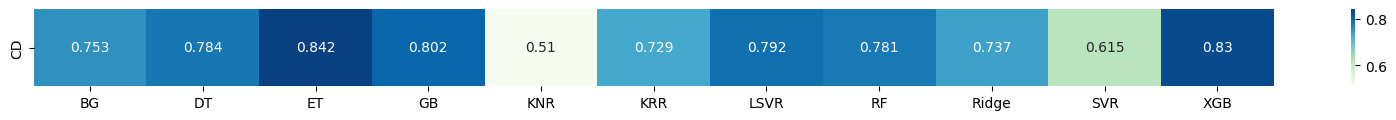

In [11]:
r2_map = np.zeros((len(desc_names),len(model_names)))
for i,m in enumerate(model_names):
    for j,d in enumerate(desc_names):
        r2_map[j,i] = performance_dict['%s-%s'%(m,d)][2]

fig = plt.figure(figsize=(20,1))
sns.heatmap(r2_map,annot=True,fmt='.3g',xticklabels=model_names,yticklabels=desc_names,cmap='GnBu')

Text(-4, 1.6, 'MAE: 0.692')

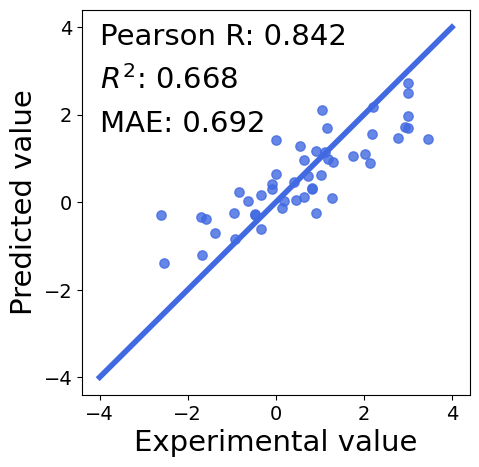

In [12]:
model = 'ET-CD'
train_y = performance_dict[model][4]
train_p = performance_dict[model][3]

colour='royalblue'
word=21
fig = plt.figure(figsize=(5,5))

plt.xticks([-4,-2,0,2,4],fontsize=14)
plt.yticks([-4,-2,0,2,4],fontsize=14)

plt.xlabel('Experimental value',fontsize=word)
plt.ylabel('Predicted value',fontsize=word)

plt.plot([-4,4],[-4,4],c=colour,linewidth=4)

plt.scatter(np.array(train_y),np.array(train_p),c=colour,s=45, alpha=0.8)

plt.text(-4,3.6,'Pearson R: %.3f'%pearsonr(np.array(train_y),np.array(train_p))[0],fontsize=word)
plt.text(-4,2.6,'$R^2$: %.3f'%(r2_score(np.array(train_y),np.array(train_p))),fontsize=word)
plt.text(-4,1.6,'MAE: %.3f'%mean_absolute_error(np.array(train_y),np.array(train_p)),fontsize=word)

# Descriptor Selection

In [ ]:
des_sel_max=28
tem_des_sel=[]
max_pear,max_r2,max_mae,tem_des_sel_max=circle(des_all_std[0:train_num,:28],lable=ratio_log[0:train_num],model=ExtraTreesRegressor(random_state=random_seed,n_jobs=60),des_len=28,tem_des_sel=tem_des_sel)
print(max_pear,max_r2,max_mae,tem_des_sel_max)
result=[]
while True:
    tem_des_sel=tem_des_sel_max
    max_pear,max_r2,max_mae,tem_des_sel_max=circle(des_all_std[0:train_num,:28],lable=ratio_log[0:train_num],model=ExtraTreesRegressor(random_state=random_seed,n_jobs=60),des_len=28,tem_des_sel=tem_des_sel)
    result.append([max_pear,max_r2,max_mae,tem_des_sel_max])
    print(max_pear,max_r2,max_mae,tem_des_sel_max)
    if len(tem_des_sel_max) ==des_sel_max:
        break
    else:
        continue

[0.67749103] [0.39565286] 0.8866187511446957 [9]
[0.73973139] [0.54641744] 0.7636284087362525 [9, 11]


# Prediction 

In [ ]:
sel_index = [9, 11, 5, 25, 26, 18, 17, 16, 21, 15, 13, 24, 8, 19, 2]
des_sel=des_all_std[:train_num,sel_index]
ratio_log_train=ratio_log[0:train_num]
model = ExtraTreesRegressor(random_state=random_seed,n_jobs=60)
all_r2 = []
all_pearsr = []
all_mae = []
repeat_pred = []
repeat_test = []
for i in range(10):
    all_pred = []
    all_test = []
    for train_index_tep,test_index_tep in loo.split(des_sel):
        train_x,test_x = des_sel[train_index_tep],des_sel[test_index_tep]
        train_y,test_y = ratio_log_train[train_index_tep],ratio_log_train[test_index_tep] 
        model.fit(train_x,train_y)
        test_pred = model.predict(test_x)
        all_pred.append(test_pred)
        all_test.append(test_y)
    all_pred = np.concatenate(all_pred)
    all_test = np.concatenate(all_test).reshape(-1)
    repeat_pred.append(all_pred)
    repeat_test.append(all_test)
train_p = np.mean(repeat_pred,axis=0)
train_y = np.mean(repeat_test,axis=0)

# Results

In [ ]:
colour='royalblue'
word=21
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5,5))

plt.xticks([-4,-2,0,2,4],fontsize=14)
plt.yticks([-4,-2,0,2,4],fontsize=14)

plt.xlabel('Experimental value',fontsize=word)
plt.ylabel('Predicted value',fontsize=word)
plt.plot([-4,4],[-4,4],c=colour,linewidth=4)

plt.scatter(np.array(train_y),np.array(train_p),c=colour,s=45, alpha=0.8)

plt.text(-4,3.6,'Pearson R: %.3f'%pearsonr(np.array(train_y),np.array(train_p))[0],fontsize=word)
plt.text(-4,2.6,'$R^2$: %.3f'%(r2_score(np.array(train_y),np.array(train_p))),fontsize=word)
plt.text(-4,1.6,'MAE: %.3f'%mean_absolute_error(np.array(train_y),np.array(train_p)),fontsize=word)

#　次回  
https://colab.research.google.com/github/ARIM-Training/Training_python_7/blob/main/Notebook2_compounds_loo_prediction.ipynb